# Library preparation

In [104]:
# Required libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from pycop import archimedean, estimation, gaussian, student, simulation, mixture
from scipy.stats import multivariate_normal, t
import warnings
warnings.filterwarnings("ignore")

In [105]:
# Set random seed to ensures reproducibility of Monte Carlo simulations
np.random.seed(25585391)

# 1. Dataset preparation
In this section, we clean our financial historical data including `CBA` and `MQG` stock prices and transform data into log-returns to match the risk factor mapping.

In [106]:
# Load dataset
df = pd.read_csv("FinDataSet-1.csv")
df.index = pd.to_datetime(df["Date"], format="%d/%m/%Y")

# Remove invalid data where CBA price = $1 
df = df.drop(df[(df["CBA"] == 1)].index)

df.head()

,Date,CBA,MQG
Date,,,
2013-01-02,2/1/2013,73.134,38.539
2013-01-03,3/1/2013,72.636,37.851
2013-01-04,4/1/2013,72.188,38.235
2013-01-07,7/1/2013,70.754,42.394
2013-01-08,8/1/2013,71.362,43.368


In [107]:
# Current values of financial variables
current_values = df.tail(1).to_numpy()
CBA_price = current_values[0,1]
MQG_price = current_values[0,2]

In [108]:
# Store price data to plot in the Extra Material section
price_df = df.copy()

# Drop other columns
df = df.drop(["Date"], axis=1)

# Calculate the daily log-return:
for col in df.columns.values:
    df.loc[:,col] = np.log(df.loc[:,col]) - np.log(df.loc[:,col].shift(1))

# Remove na rows
df = df.dropna()
df.head()

,CBA,MQG
Date,,
2013-01-03,-0.006833,-0.018013
2013-01-04,-0.006187,0.010094
2013-01-07,-0.020065,0.103256
2013-01-08,0.008556,0.022715
2013-01-09,-0.019299,0.011486


In [109]:
# Covariance matrix of (daily) log returns
daily_log_ret_cov = np.cov(df, rowvar = False)
daily_log_ret_cov

# Calculate annual volatility of each stock based on historical data
CBA_ann_vol = np.sqrt(daily_log_ret_cov[0,0] * 250)
MQG_ann_vol = np.sqrt(daily_log_ret_cov[1,1] * 250)

# 2. Portfolio Value

Our entire portfolio contains 2 position including Butterfly Spread ($B$) and Strangle ($S$), the following is how we can calculate the portfolio value (denoted by $V$) assuming that Black-Scholes-Mertan holds,

## The entire portfolio value:

$$ V_t = V^{B}_{t} + V^{S}_{t} $$

Where each position value as follows:
$$\begin{align*}
V^{B}_{t} &= V^{B80}_{\text{call}} \left( t, S^{B}_{t} \right) + V^{B110}_{\text{call}} \left( t, S^{B}_{t} \right) - 2 \times V^{B100}_{\text{call}} \left( t, S^{B}_{t} \right) \\[5pt]
V^{S}_{t} &= V^{S150}_{\text{put}} \left( t, S^{S}_{t} \right) + V^{S220}_{\text{call}} \left( t, S^{S}_{t} \right) 
\end{align*}$$

Now we apply the Black-Scholes-Merton model to determine the mark-to-market value by the following `BSprice`. This function require some parameters involving in Black-Scholes-Merton model, which are:<br>
`spot_price`      : The stock price at the expiration date<br>
`strike_price`    : Strike price of CBA and MQG stock equivalent to each option<br>
`time_to_maturity`: Time of maturity, which is fixed 0.5 year in our case<br>
`risk_free_rate`  : 6-month risk-free rate of interest is also fixed at 2.67%<br>
`dividend_yield`  : Assume 0 (zero) dividend yield in our project<br>
`volatility`      : Annual log-return volatility<br>
`option_type`     : Is option "Call" or "Put"<br>

In [110]:
# Pricing function for European calls and puts
def BSprice(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Calculate option prices
    if option_type == 'call':
        price = (np.exp(-q * tau) * s * sp.stats.norm.cdf(d1, 0.0, 1.0) \
                 - np.exp(-r * tau) * K * sp.stats.norm.cdf(d2, 0.0, 1.0))
        
    if option_type == 'put':
        price = (np.exp(-r * tau) * K * sp.stats.norm.cdf(-d2, 0.0, 1.0) \
                 - np.exp(-q * tau) * s * sp.stats.norm.cdf(-d1, 0.0, 1.0))
        
    return price

In [111]:
# Assign fixed values:
rfr = 0.0267   # risk-free interest rate in 6 months
tau = 0.5      # time of maturity
dy = 0         # assume zero dividend yield

# Assign strike prices for each option of the Butterfly Spread:
CBA_long_call_strike_1 = 80    # Long Call Strike K1
CBA_short_call_strike_2 = 100  # Short Call Strike K2
CBA_long_call_strike_3 = 110   # Long Call Strike K3

# Assign strike prices for each option of the Strangle:
MQG_long_put_strike_1 = 150    # Long Put Strike K1
MQG_long_call_strike_2 = 220   # Long Call Strike K2

# Calculate the mark-to-market value of the Butterfly Spread under Black-Scholes-Merton:
B_CBA_long_call_1 = BSprice(CBA_price, CBA_long_call_strike_1, tau, rfr, dy, CBA_ann_vol, "call")
B_CBA_short_call_2 = 2 * BSprice(CBA_price, CBA_short_call_strike_2, tau, rfr, dy, CBA_ann_vol, "call")
B_CBA_long_call_3 = BSprice(CBA_price, CBA_long_call_strike_3, tau, rfr, dy, CBA_ann_vol, "call")
B_value = B_CBA_long_call_1 - B_CBA_short_call_2 + B_CBA_long_call_3

# Calculate the mark-to-market value of the Strangle under Black-Scholes-Merton:
S_MQG_long_put_1 = BSprice(MQG_price, MQG_long_put_strike_1, tau, rfr, dy, MQG_ann_vol, "put")
S_MQG_long_call_2 = BSprice(MQG_price, MQG_long_call_strike_2, tau, rfr, dy, MQG_ann_vol, "call")
S_value = S_MQG_long_put_1 + S_MQG_long_call_2

In [112]:
# Print values
print("Value/Premium paid of Long Call CBA K1    : ", B_CBA_long_call_1)
print("Value/Premium paid of 2 Short Calls CBA K2: ", B_CBA_short_call_2)
print("Value/Premium paid of Long Call CBA K3    : ", B_CBA_long_call_3)
print("Total value of the Butterfly Spread       : ", B_value, "\n")

print("Value/Premium paid of Long Put MQG K1     : ", S_MQG_long_put_1)
print("Value/Premium paid of Long Call MQG K2    : ", S_MQG_long_call_2)
print("Total value of the Strangle               : ", S_value, "\n")

print("Total value of the entire portfolio       : ", B_value + S_value)

Value/Premium paid of Long Call CBA K1    :  22.12130476157543
Value/Premium paid of 2 Short Calls CBA K2:  14.135415619525205
Value/Premium paid of Long Call CBA K3    :  3.1208965979871763
Total value of the Butterfly Spread       :  11.106785740037402 

Value/Premium paid of Long Put MQG K1     :  2.032431547396854
Value/Premium paid of Long Call MQG K2    :  3.0710093124877
Total value of the Strangle               :  5.103440859884554 

Total value of the entire portfolio       :  16.210226599921956


# 3. Implement methods from (M1) to (M5) to calculate risk measures for diversified portfolio

## Risk Factor Mapping

We introduce the following notation:

$$
\mathbf{Z}_t := \begin{bmatrix} Z_{1,t} \\ Z_{2,t} \end{bmatrix} = \begin{bmatrix} \ln S^{B}_{t} \\ \ln S^{S}_{t}  \end{bmatrix}, \quad \mathbf{X}_{t+1} := \mathbf{Z}_{t+1} - \mathbf{Z}_t = \begin{bmatrix} \ln S^{B}_{t+1} - \ln S^{B}_{t} \\ \ln S^{S}_{t+1} - \ln S^{S}_{t} \end{bmatrix}
$$

A mapping, therefore, of the risk factor vector $Z_t$ to the current portfolio value is
$$\begin{align*}
V_t &= g(t, \mathbf{Z}_t) \\
&:= V_{\text{B}} \left( t, e^{Z_{1,t}} \right) + V_{\text{S}} \left( t, e^{Z_{2,t}} \right).
\end{align*}$$

We then implement 5 methods to calculate risk measures including VaR and ES for 1-day and 10-day at various confidence level (0.90, 0.95 and 0.99). For $\psi \in \{ \text{VaR}_{\alpha}, \text{ES}_{\alpha} \}$, the *diversified* portfolio risk measure is obtained by first aggregating the individual losses then calculating the risk measures on the total loss:
$$
\psi(L_{t+1}) = \psi\left( L_{\text{B}, t+1} + L_{\text{S}, t+1} \right)
$$

## 3.1. (M1) Analytical delta-normal approach

In [113]:
# Create dataframe to store all values
portfolio_risk_measures = pd.DataFrame(columns=['method', 'position', 'time_period', 'conf_level', 'risk_measure'])

# Confidence level list 
conf_level_list = [0.9, 0.95, 0.99]

First, we write a function `BSdelta` to calculate $\Delta_{\text{call}}(t, s)$ and $\Delta_{\text{put}}(t, s)$:

In [114]:
# Function to calculate option delta under the Black-Scholes-Merton model
def BSdelta(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    
    # Calculate option delta
    if option_type == 'call':
        value = sp.stats.norm.cdf(d1, 0.0, 1.0)
    
    if option_type == 'put':
        value = sp.stats.norm.cdf(d1, 0.0, 1.0) - 1
    
    return value    

We then calculate the Delta risk exposures for the entire portfolio and also each position including Butterfly Spread and Strangle,

In [115]:
# Obtain the portfolio delta exposure under delta approximation
# Call Option Risk Factor Exposures
# - Call delta
# -- for CBA stock
call_delta_B_long_1 = BSdelta(CBA_price, CBA_long_call_strike_1, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol, option_type = 'call')
call_delta_B_short_2 = BSdelta(CBA_price, CBA_short_call_strike_2, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol, option_type = 'call')
call_delta_B_long_3 = BSdelta(CBA_price, CBA_long_call_strike_3, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol, option_type = 'call')

# -- for MQG stock
call_delta_S_long_2 = BSdelta(spot_price = MQG_price, strike_price = MQG_long_call_strike_2, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol, option_type = 'call')

# Put Option Risk Factor Exposures
# - Put delta
# -- for MQG stock
put_delta_S_long_1 = BSdelta(spot_price = MQG_price, strike_price = MQG_long_put_strike_1, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol, option_type = 'put')

# Butterfly Spread Risk Factor Delta Exposures
B_exposure_delta_1 = (call_delta_B_long_1 + call_delta_B_long_3 - 2*call_delta_B_short_2) * CBA_price
B_exposure_delta_2 = 0
B_exposure_delta = np.array([B_exposure_delta_1, B_exposure_delta_2])

# Strangle Risk Factor Delta Exposures
S_exposure_delta_1 = 0
S_exposure_delta_2 = (put_delta_S_long_1 + call_delta_S_long_2) * MQG_price
S_exposure_delta = np.array([S_exposure_delta_1, S_exposure_delta_2])

# Entire portfolio Delta Exposures
exposure_delta = B_exposure_delta + S_exposure_delta

We write a function `EWMA_cov` to estimate covariance matrix of next-day log-returns applying Exponentially Weighted Moving Average (EWMA) framework, let $Sigma$ denote the covariance matrix, the formula of EWMA is:
$$\Sigma_{t+1} = \theta \left( X_t - \hat{\mu}_t \right) \left( X_t - \hat{\mu}_t \right)^\top + (1 - \theta) \Sigma_t$$
In which $\theta$ is a decay factor to give more weight to current events. We use $\theta=0.06$ as recommended from $\textit{RiskMetrics (1996)}$

In [116]:
# Function for EWMA estimator of the returns time series
def EWMA_cov(returns_time_series, time, smoothing_constant):
    
    data = returns_time_series
    theta = smoothing_constant

    # - Return error message if time is incorrect
    if (time < 1 or time > (data.shape[0])):
        print("Invalid `time` value")

    # - Perform recursion to update EWMA covariance matrix up until specified time
    else:
        
        # - Extract the time series of specified length from the input time series
        data_extract = data.head(time)

        # - Normalize the returns and convert to a numpy array
        normalized = (data_extract - data_extract.mean()).fillna(0).to_numpy()

        # - Calculate the weights
        weights = (1 - theta) ** np.arange(len(data_extract))[::-1]        

        # - Calculate EWMA estimate of covariance matrix
        cov = (weights * normalized.T) @ normalized * theta
        
        return cov

In [117]:
# Calculate historical log-returns' mean
daily_log_ret_mean = np.mean(df, axis = 0)
daily_log_ret_mean

# Calculate historical 10-day log-returns' mean
log_ret_mean_10days = daily_log_ret_mean * 10

# Estimate EWMA covariance
ewma_log_ret_cov = EWMA_cov(df, len(df), 0.06)

# Estimate 10-day EWMA covariance
ewma_log_ret_cov_10days = ewma_log_ret_cov * 10

Function `VaR_ES_vcv` is built to apply Variance-Covariance method to calculate VaR and ES as follows:
$$\text{VaR}_{\alpha}(L_{t+h}^{\Delta}) =  h\mu + \sqrt{h}\sqrt{\mathbf{b}_t^\top \Sigma \mathbf{b}_t} \Phi^{-1}(\alpha),$$
$$
\text{ES}_{\alpha}(L_{t+h}^{\Delta}) = h\mu +\sqrt{h}\sqrt{\mathbf{b}_t^\top \Sigma \mathbf{b}_t} \frac{\phi(\Phi^{-1}(\alpha))}{1 - \alpha}.
$$
For the case of 10-day risk measures, we use `log_ret_mean_10days` and `ewma_log_ret_cov_10days` computed above.

In [118]:
# Functions for VaR and ES under the variance-covariance approach
def VaR_ES_vcv(constant_loss, risk_exposure, risk_factor_mean, risk_factor_cov_mat, conf_level):

    # Shorthand notation for inputs
    c = constant_loss
    b = risk_exposure
    mu = risk_factor_mean
    Sigma = risk_factor_cov_mat
    alpha = conf_level

    # Compute mean and variance of loss
    loss_mean = -c - np.transpose(b) @ mu
    loss_var = np.transpose(b) @ Sigma @ b

    # Compute VaR
    VaR = loss_mean + np.sqrt(loss_var) * stats.norm.ppf(alpha, loc = 0.0, scale = 1.0)
    VaR = max(VaR, 0)

    # Compute ES
    ES = loss_mean + np.sqrt(loss_var) * stats.norm.pdf(stats.norm.ppf(alpha, loc = 0.0, scale = 1.0), loc = 0.0, scale = 1.0) / (1 - alpha)
    ES = max(ES, 0)

    # Return output
    return np.array([VaR, ES])

In [119]:
# Compute 1-day VaR and ES for each confidence level
new_rows = []
for i in conf_level_list:
    risk_measure = VaR_ES_vcv(0, exposure_delta, daily_log_ret_mean, ewma_log_ret_cov, i)
    new_row = {'method': 'M1', 'position': 'diversified', 'time_period': '1-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row)

# Compute 10-day VaR and ES for each confidence level
for i in conf_level_list:
    risk_measure = VaR_ES_vcv(0, exposure_delta, log_ret_mean_10days, ewma_log_ret_cov_10days, i)
    new_row = {'method': 'M1', 'position': 'diversified', 'time_period': '10-day', 'conf_level': i, 'risk_measure': risk_measure}
    new_rows.append(new_row)

# Add new risk measures rows to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_rows)], ignore_index=True)

In [120]:
portfolio_risk_measures[portfolio_risk_measures['method']=='M1']

,method,position,time_period,conf_level,risk_measure
0,M1,diversified,1-day,0.90,"[0.4085180908327957, 0.5629801148064156]"
1,M1,diversified,1-day,0.95,"[0.5270491595044986, 0.6633800546108438]"
2,M1,diversified,1-day,0.99,"[0.7493937316445798, 0.8599523946173716]"
3,M1,diversified,10-day,0.90,"[1.226195855730494, 1.7146476634866645]"
4,M1,diversified,10-day,0.95,"[1.601024006226904, 2.0321401502124585]"
5,M1,diversified,10-day,0.99,"[2.3041392795651796, 2.653756469622124]"


## 3.2. (M2) Historical simulation approach with a delta-gamma approximation

For method M2 and the rest, we compute VaR and ES under a delta-gamma approximation. Therefore, we need a function `BSgamma` to calculate $\Gamma_{\text{call}}(t, s)$ and $\Gamma_{\text{put}}(t, s)$:

In [121]:
# Function to calculate option gamma under the Black-Scholes-Merton model
def BSgamma(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Compute option gamma (same for calls and puts)
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    value = sp.stats.norm.pdf(d1, 0.0, 1.0) / (s * sigma * np.sqrt(tau))
    
    return value

In [122]:
# Obtain the portfolio Delta-gamma exposure under delta-gamma approximation
# Call Option Risk Factor Exposures
# - Call gamma
# -- for CBA stock
call_gamma_B_long_1 = BSgamma(spot_price = CBA_price, strike_price = CBA_long_call_strike_1, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)
call_gamma_B_short_2 = BSgamma(spot_price = CBA_price, strike_price = CBA_short_call_strike_2, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)
call_gamma_B_long_3 = BSgamma(spot_price = CBA_price, strike_price = CBA_long_call_strike_3, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = CBA_ann_vol)

# -- for MQG stock
call_gamma_S_long_2 = BSgamma(spot_price = MQG_price, strike_price = MQG_long_call_strike_2, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol)

# Put Option Risk Factor Exposures
# - Put gamma
put_gamma_S_long_1 = BSgamma(spot_price = MQG_price, strike_price = MQG_long_put_strike_1, time_to_maturity = tau, 
                     risk_free_rate = rfr, dividend_yield = dy, volatility = MQG_ann_vol)

# Butterfly Spread Risk Factor Delta-gamma Exposures
B_exposure_dg = np.zeros([df.shape[1], df.shape[1]])
B_exposure_dg[0,0] = B_exposure_delta[0] + (call_gamma_B_long_1 + call_gamma_B_long_3 - 2*call_gamma_B_short_2) * (CBA_price**2)

# Strangle Risk Factor Delta-Gamma Exposures
S_exposure_dg = np.zeros([df.shape[1], df.shape[1]])
S_exposure_dg[1,1] = S_exposure_delta[1] + (put_gamma_S_long_1 + call_gamma_S_long_2) * (MQG_price**2)

# Entire portfolio Delta-Gamma Exposures
exposure_dg = B_exposure_dg + S_exposure_dg

In Historical simulation (M2) and Weighted historical simulation (M3), we first calculate potential loss from historical data of log-returns of CBA and MQG. Function `HS_loss_scenario` transform that historical log-returns to a list of potential loss under delta-gamma approximation.

Moreover, parameter `time` used to optionally split data into groups of non-overlapping consecutive days, input `1` or `10` for our case.

In [123]:
# Function to design loss scenario under historical simulation
def HS_loss_scenario(data, risk_exposure_delta, risk_exposure_dg, time):
    # Declare scenarios of loss
    loss_scenario = pd.DataFrame(columns=['scenario', 'loss'])

    # Number of non-overlapping observations
    n = math.floor(len(data)/time)

    # Design historical data by excluding redundant older data:
    new_df = data.iloc[len(data) - n*time:].copy()

    # Potential loss under delta-gamma approximation
    for i in range(0, n):
        log_return = np.sum(new_df.iloc[i*time:i*time+time])
        log_return = log_return.values.reshape(-1, 1) # Shape log_return to column vector
        loss_dg = - (risk_exposure_delta @ log_return + 0.5 * np.diag(log_return.T @ risk_exposure_dg @ log_return))[0]

        # Store loss value
        new_row = [{'scenario': i+1, 'loss': loss_dg}]
        loss_scenario = pd.concat([loss_scenario, pd.DataFrame(new_row)], ignore_index=True)

    return loss_scenario

Now, we have function `HS` to implement Historical simulation (M4) and Weighted historical simulation (M5) in order to calculate VaR and ES, in which `hs_weight_type == "equal"` represents the case of M4 and `hs_weight_type == "BRW"` is used for M5.

Additionally, the decay factor $\lambda$ is predefined at `0.94` as recommended from *RiskMetrics (1996)*

In [124]:
# Write function to implement historical simulation
def HS(data, risk_exposure_delta, risk_exposure_dg, hs_weight_type, time, conf_level, age_weight_decay=0.94):
    
    # Construct potential loss
    loss_scenario = HS_loss_scenario(data, risk_exposure_delta, risk_exposure_dg, time)

    if hs_weight_type == "equal":
        
        # Compute VaR and ES
        VaR = np.quantile(loss_scenario['loss'], conf_level, method = "higher") 
        ES = np.maximum(loss_scenario['loss'] - VaR, 0).mean() / (1 - conf_level) + VaR
    
        # Store value
        risk_measure = np.array([VaR, ES])
         
    elif hs_weight_type == "BRW":
    
        # Design loss scenario
        n = len(loss_scenario)
        j = n - loss_scenario['scenario'] + 1
        loss_scenario['weight'] = (age_weight_decay ** (j - 1)) * (1-age_weight_decay) / (1 - age_weight_decay ** n)
        
        # Rank loss value ascendingly and calculate cumulative weight
        loss_scenario = loss_scenario.sort_values(by='loss', ascending=True) 
        loss_scenario['cum_weight'] = loss_scenario['weight'].cumsum()
    
        # Detect loss values from VaR threshold
        loss_exceed = loss_scenario[(loss_scenario['cum_weight'] >= conf_level)]
    
        # Compute VaR and ES
        VaR = min(loss_exceed['loss'])
        ES = sum((loss_exceed['loss'] - VaR) * loss_exceed['weight']) / (1 - conf_level) + VaR
    
        # Store value
        risk_measure = np.array([VaR, ES])
        
    return risk_measure

In [125]:
# Implement historical simulation
for conf_level in conf_level_list:

    # Historical simulation for 1-day risk measure
    hs_1_day = HS(df, exposure_delta, exposure_dg, 'equal', 1, conf_level)
    risk_measure_1_day = [{'method': 'M2', 
                           'position': 'diversified', 
                           'time_period': '1-day', 
                           'conf_level': conf_level, 
                           'risk_measure': hs_1_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_1_day)], ignore_index=True)


    # Historical simulation for 10-day risk measure
    hs_10_day = HS(df, exposure_delta, exposure_dg, 'equal', 10, conf_level)
    risk_measure_10_day = [{'method': 'M2', 
                           'position': 'diversified', 
                           'time_period': '10-day', 
                           'conf_level': conf_level, 
                           'risk_measure': hs_10_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_10_day)], ignore_index=True)

In [126]:
portfolio_risk_measures[portfolio_risk_measures['method']=='M2']

,method,position,time_period,conf_level,risk_measure
6,M2,diversified,1-day,0.90,"[0.275571883033393, 0.44525492655627974]"
7,M2,diversified,10-day,0.90,"[0.7225033098293504, 1.3491335132028448]"
8,M2,diversified,1-day,0.95,"[0.38640233546881236, 0.566174125790744]"
9,M2,diversified,10-day,0.95,"[1.0442822480252383, 1.8072708729133162]"
10,M2,diversified,1-day,0.99,"[0.6212339173649769, 0.9027528796050628]"
11,M2,diversified,10-day,0.99,"[2.245525789175568, 3.161838287626614]"


## 3.3. (M3) Weighted istorical simulation approach with a delta-gamma approximation

In [127]:
# Implement historical simulation
for conf_level in conf_level_list:

    # Historical simulation for 1-day risk measure
    whs_1_day = HS(df, exposure_delta, exposure_dg, 'BRW', 1, conf_level)
    risk_measure_1_day = [{'method': 'M3', 
                           'position': 'diversified', 
                           'time_period': '1-day', 
                           'conf_level': conf_level, 
                           'risk_measure': whs_1_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_1_day)], ignore_index=True)


    # Historical simulation for 10-day risk measure
    whs_10_day = HS(df, exposure_delta, exposure_dg, 'BRW', 10, conf_level)
    risk_measure_10_day = [{'method': 'M3', 
                           'position': 'diversified', 
                           'time_period': '10-day', 
                           'conf_level': conf_level, 
                           'risk_measure': whs_10_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_10_day)], ignore_index=True)

In [128]:
portfolio_risk_measures[portfolio_risk_measures['method']=='M3']

,method,position,time_period,conf_level,risk_measure
12,M3,diversified,1-day,0.90,"[0.23590751303273733, 0.4325103856670536]"
13,M3,diversified,10-day,0.90,"[0.5344811614532874, 2.1762186338672738]"
14,M3,diversified,1-day,0.95,"[0.4127314059903512, 0.5790341435790576]"
15,M3,diversified,10-day,0.95,"[2.894905178265869, 2.918452253220593]"
16,M3,diversified,1-day,0.99,"[0.6176276804701343, 0.7308264961577664]"
17,M3,diversified,10-day,0.99,"[2.894905178265869, 3.01264055303949]"


## 3.4. (M4) Monte Carlo simulation approach with a delta-gamma approximation, assuming that log-returns have a joint Gaussian distribution

In method M4, we need to simulate 10,000 pairs of $(Z_B, Z_S)$ and use it to calculate log-returns for both CBA and MQG stocks under geometric Brownian motions model. Function `MCGaussian_Sim_loss` is built to generate those simulations.

$Corr(Z_B, Z_S)$ denoted by $\rho$ is predefined at `0.57` as a result of computing correlation from historical data.

Simulated log-returns are calculated by:
$$\mathbf{X}_{i,\Delta t} = \left( \mu_i - \frac{1}{2} \sigma_i^2 \right) \Delta t + \sigma_i \sqrt{\Delta t} Z_i$$

In [129]:
# Function to implement Monte Carlo simulation with Joint Gaussian distribution
def MCGaussian_Sim_loss(mu, cov, sim_size, time, rho=0.57):

    # Assign value
    mu1 = mu[0] * 250
    mu2 = mu[1] * 250
    sigma1 = np.sqrt(cov[0,0] * 250)
    sigma2 = np.sqrt(cov[1,1] * 250)
    dt = time/250
    
    # Covariance matrix of (Z1, Z2)
    cov_mat = np.array([[1, rho], [rho, 1]])    # Equal to correlation matrix since marginals and standard normal
    
    # Simulate random sample
    Z_sim = multivariate_normal.rvs(cov = cov_mat, size = sim_size)
    
    # Calculate corresponding log-returns
    log_ret1_sim = (mu1 - 0.5 * (sigma1 ** 2)) * dt + sigma1 * np.sqrt(dt) * Z_sim[:,0]
    log_ret2_sim = (mu2 - 0.5 * (sigma2 ** 2)) * dt + sigma2 * np.sqrt(dt) * Z_sim[:,1]

    return pd.DataFrame({'CBA': log_ret1_sim, 'MQG': log_ret2_sim})

In [130]:
# Simulate log_return by Monte Carlo simulation approach with joint gaussian distribution
Gauss_log_return_1_day = MCGaussian_Sim_loss(daily_log_ret_mean, daily_log_ret_cov, 10000, 1)
Gauss_log_return_10_day = MCGaussian_Sim_loss(daily_log_ret_mean, daily_log_ret_cov, 10000, 10)

# Implement Monte Carlo simulation with a delta-gamma approximation to compute VaR and ES
for conf_level in conf_level_list:

    # Historical simulation for 1-day risk measure
    mc_1_day = HS(Gauss_log_return_1_day, exposure_delta, exposure_dg, 'equal', 1, conf_level)
    risk_measure_1_day = [{'method': 'M4', 
                           'position': 'diversified', 
                           'time_period': '1-day', 
                           'conf_level': conf_level, 
                           'risk_measure': mc_1_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_1_day)], ignore_index=True)


    # Historical simulation for 10-day risk measure
    mc_10_day = HS(Gauss_log_return_10_day, exposure_delta, exposure_dg, 'equal', 1, conf_level) # Set 1 since already have 10-day log returns
    risk_measure_10_day = [{'method': 'M4', 
                           'position': 'diversified', 
                           'time_period': '10-day', 
                           'conf_level': conf_level, 
                           'risk_measure': mc_10_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_10_day)], ignore_index=True)

In [131]:
portfolio_risk_measures[portfolio_risk_measures['method']=='M4']

,method,position,time_period,conf_level,risk_measure
18,M4,diversified,1-day,0.90,"[0.34167151088110287, 0.46387984570997015]"
19,M4,diversified,10-day,0.90,"[0.8552115906155591, 1.3236806641770664]"
20,M4,diversified,1-day,0.95,"[0.4356869991995467, 0.543280792354368]"
21,M4,diversified,10-day,0.95,"[1.2116708611795572, 1.6305658072057854]"
22,M4,diversified,1-day,0.99,"[0.6194627010711732, 0.7015888075663578]"
23,M4,diversified,10-day,0.99,"[1.882825248624321, 2.2324024916825422]"


## 3.5. (M5) Monte Carlo simulation approach with a delta-gamma approximation, assuming that the joint distribution of the log-returns are modelled using a Student’s $\mathit{t}$ copula

This method requires simulations of probability-transformed observations of the log-returns $(F_1(X_B), F_2(X_S))$ reflecting the dependence structure modelled by the Student's *t* copula. Hence, we calculate the quantile values of these function to obtain simulated values of the log-returns.

However, we first determine optimal $\nu$ (degrees of freedom) and $\varrho$ (correlation parameter for the bivariate distribution) thanks to `pycop` library.

In [132]:
# Estimate Student's t copula
cop_dat = df.T.values
cop_t = student()
cop_t_param, cop_t_cmle = estimation.fit_cmle(cop_t, cop_dat)

# Print the optimal Sigma and degree of freedom for its
print('Optimal degrees of freedom: ', cop_t_param[1])
print('Optimal correlation parameter: ', cop_t_param[0])

Optimal degrees of freedom:  3.096552716165432
Optimal correlation parameter:  0.5760765649508242


Below function `MCStudentT_Sim_loss` returns simulations for log-returns of CBA and MQG stocks. Simulated log-returns are calculated by:
$$\mathbf{X}_{i,\Delta t} = \left( \mu_i - \frac{1}{2} \sigma_i^2 \right) \Delta t + \sigma_i \sqrt{\Delta t} \Phi^{-1}(u_i)$$

In [133]:
# Function to implement Monte Carlo simulation with Student's t copula
def MCStudentT_Sim_loss(mu, cov, sim_size, time, varrho=cop_t_param[0], df=cop_t_param[1]):

    # Assign value
    mu1 = mu[0] * 250
    mu2 = mu[1] * 250
    sigma1 = np.sqrt(cov[0,0] * 250)
    sigma2 = np.sqrt(cov[1,1] * 250)
    dt = time/250

    # Corralation matrix of copula
    cor_mat = np.array([[1, varrho], [varrho, 1]])    
    
    # Simulate variables 
    student_sim = simulation.simu_tstudent(n=2, m=sim_size, corr_matrix=cor_mat, nu=df) # use corr matrix for the copula, not the data

    # Calculate corresponding log-returns
    log_ret1_sim = (mu1 - 0.5 * (sigma1 ** 2)) * dt + sigma1 * np.sqrt(dt) * stats.norm.ppf(student_sim[0])
    log_ret2_sim = (mu2 - 0.5 * (sigma2 ** 2)) * dt + sigma2 * np.sqrt(dt) * stats.norm.ppf(student_sim[1])

    return pd.DataFrame({'CBA': log_ret1_sim, 'MQG': log_ret2_sim})

In [134]:
# Simulate log_return by Monte Carlo simulation approach with student's copula
Stu_log_return_1_day = MCStudentT_Sim_loss(daily_log_ret_mean , daily_log_ret_cov, 10000, 1)
Stu_log_return_10_day = MCStudentT_Sim_loss(daily_log_ret_mean, daily_log_ret_cov, 10000, 10)

# Implement Monte Carlo simulation with a delta-gamma approximation to compute VaR and ES
for conf_level in conf_level_list:

    # Historical simulation for 1-day risk measure
    mc_1_day = HS(Stu_log_return_1_day, exposure_delta, exposure_dg, 'equal', 1, conf_level)
    risk_measure_1_day = [{'method': 'M5', 
                           'position': 'diversified', 
                           'time_period': '1-day', 
                           'conf_level': conf_level, 
                           'risk_measure': mc_1_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_1_day)], ignore_index=True)


    # Historical simulation for 10-day risk measure
    # - Set time=1 since already have a list of 10-day log-returns
    mc_10_day = HS(Stu_log_return_10_day, exposure_delta, exposure_dg, 'equal', 1, conf_level) 
    risk_measure_10_day = [{'method': 'M5', 
                           'position': 'diversified', 
                           'time_period': '10-day', 
                           'conf_level': conf_level, 
                           'risk_measure': mc_10_day}]
    portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(risk_measure_10_day)], ignore_index=True)

In [135]:
portfolio_risk_measures[portfolio_risk_measures['method']=='M5']

,method,position,time_period,conf_level,risk_measure
24,M5,diversified,1-day,0.90,"[0.3501483172451461, 0.47470583613644235]"
25,M5,diversified,10-day,0.90,"[0.8001860549212294, 1.1846910995858813]"
26,M5,diversified,1-day,0.95,"[0.44654857467543013, 0.5555441964162519]"
27,M5,diversified,10-day,0.95,"[1.0818193882211609, 1.4357742330857617]"
28,M5,diversified,1-day,0.99,"[0.6219601552251528, 0.6970487198900033]"
29,M5,diversified,10-day,0.99,"[1.661183184083208, 1.9970683666670495]"


# 4. Risk Measures for a standalone basis for each position and undiversified portfolio

For $\psi \in \{\mathsf{VaR}_\alpha, \mathsf{ES}_\alpha\}$, the *undiversified* portfolio risk measure is obtained by adding the risk measures obtained for each instrument,

$$\psi_{\text{ud}}(L_{t+1}) = \psi(L_{\text{B}, t+1}) + \psi(L_{\text{S}, t+1}).$$

Here, we implement method M1, M2, and M5 as above section to separately calculate the 1-day risk measures at 95% confidence level for each position including Butterfly Spread and Strangle. Thereafter, we obtain the *undiversified* portfolio risk measures by summing these standalone risk measures.

## 4.1. (M1) Analytical delta-normal approach

In [136]:
# Compute 1-day 95% VaR and ES for Buttefly spread
B_risk_measure = VaR_ES_vcv(0, B_exposure_delta, daily_log_ret_mean, ewma_log_ret_cov, 0.95)

# Compute 1-day 95% VaR and ES for Strangle
S_risk_measure = VaR_ES_vcv(0, S_exposure_delta, daily_log_ret_mean, ewma_log_ret_cov, 0.95)

new_row = [{'method': 'M1', 
            'position': 'undiversified', 
            'time_period': '1-day', 
            'conf_level': 0.95, 
            'risk_measure': B_risk_measure + S_risk_measure}]

# Add new 1-day 95% conf level row  to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_row)], ignore_index=True)

In [137]:
# Print 1-day 95% VaR and ES of each position
# - Butterfly Spread
print("1-day 95% VaR and ES of Butterfly Spread: ", B_risk_measure)

# - Strangle
print("1-day 95% VaR and ES of Strangle        : ", S_risk_measure)

1-day 95% VaR and ES of Butterfly Spread:  [0.26524755 0.33304785]
1-day 95% VaR and ES of Strangle        :  [0.36596822 0.46096134]


In [138]:
portfolio_risk_measures[(portfolio_risk_measures['method']=='M1') & (portfolio_risk_measures['position']=='undiversified')]

,method,position,time_period,conf_level,risk_measure
30,M1,undiversified,1-day,0.95,"[0.6312157749064611, 0.794009192780758]"


## 4.2. (M2) Historical simulation approach with a delta-gamma approximation

In [139]:
# Compute 1-day 95% VaR and ES for Buttefly spread
B_risk_measure = HS(df, B_exposure_delta, B_exposure_dg, 'equal', 1, 0.95)

# Compute 1-day 95% VaR and ES for Strangle
S_risk_measure = HS(df, S_exposure_delta, S_exposure_dg, 'equal', 1, 0.95)

# 1-day total risk measure for both position
risk_measure = B_risk_measure + S_risk_measure
new_row = [{'method': 'M2', 'position': 'undiversified', 'time_period': '1-day', 'conf_level': 0.95, 'risk_measure': risk_measure}]

# Add new 1-day 95% conf level row  to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_row)], ignore_index=True)

In [140]:
# Print 1-day 95% VaR and ES of each position
# - Butterfly Spread
print("1-day 95% VaR and ES of Butterfly Spread: ", B_risk_measure)

# - Strangle
print("1-day 95% VaR and ES of Strangle        : ", S_risk_measure)

1-day 95% VaR and ES of Butterfly Spread:  [0.29286194 0.52316079]
1-day 95% VaR and ES of Strangle        :  [0.15326155 0.16002471]


In [141]:
portfolio_risk_measures[(portfolio_risk_measures['method']=='M2') & (portfolio_risk_measures['position']=='undiversified')]

,method,position,time_period,conf_level,risk_measure
31,M2,undiversified,1-day,0.95,"[0.4461234872435701, 0.6831855017548515]"


## 4.3. (M4) Monte Carlo simulation approach with a delta-gamma approximation, assuming that log-returns have a joint Gaussian distribution

In [142]:
# Compute 1-day VaR and ES for Buttefly spread
B_risk_measure = HS(Gauss_log_return_1_day, B_exposure_delta, B_exposure_dg, 'equal', 1, 0.95)

# Compute 1-day VaR and ES for Strangle
S_risk_measure = HS(Gauss_log_return_1_day, S_exposure_delta, S_exposure_dg, 'equal', 1, 0.95)

# 1-day total risk measure for both position
risk_measure = B_risk_measure + S_risk_measure
new_row = [{'method': 'M4', 'position': 'undiversified', 'time_period': '1-day', 'conf_level': 0.95, 'risk_measure': risk_measure}]

# Add new 1-day rows to portfolio_risk_measures
portfolio_risk_measures = pd.concat([portfolio_risk_measures, pd.DataFrame(new_row)], ignore_index=True)

In [143]:
# Print 1-day 95% VaR and ES of each position
# - Butterfly Spread
print("1-day 95% VaR and ES of Butterfly Spread: ", B_risk_measure)

# - Strangle
print("1-day 95% VaR and ES of Strangle        : ", S_risk_measure)

1-day 95% VaR and ES of Butterfly Spread:  [0.31682434 0.42209403]
1-day 95% VaR and ES of Strangle        :  [0.15998142 0.16253462]


In [144]:
portfolio_risk_measures[(portfolio_risk_measures['method']=='M4') & (portfolio_risk_measures['position']=='undiversified')]

,method,position,time_period,conf_level,risk_measure
32,M4,undiversified,1-day,0.95,"[0.4768057562940945, 0.5846286462526843]"


# Results for VaR and ES from All 5 Methods

Below is a summary of our risk measures after implementing 5 methods:

In [145]:
portfolio_risk_measures

,method,position,time_period,conf_level,risk_measure
0,M1,diversified,1-day,0.90,"[0.4085180908327957, 0.5629801148064156]"
1,M1,diversified,1-day,0.95,"[0.5270491595044986, 0.6633800546108438]"
2,M1,diversified,1-day,0.99,"[0.7493937316445798, 0.8599523946173716]"
3,M1,diversified,10-day,0.90,"[1.226195855730494, 1.7146476634866645]"
4,M1,diversified,10-day,0.95,"[1.601024006226904, 2.0321401502124585]"
5,M1,diversified,10-day,0.99,"[2.3041392795651796, 2.653756469622124]"
6,M2,diversified,1-day,0.90,"[0.275571883033393, 0.44525492655627974]"
7,M2,diversified,10-day,0.90,"[0.7225033098293504, 1.3491335132028448]"
8,M2,diversified,1-day,0.95,"[0.38640233546881236, 0.566174125790744]"
9,M2,diversified,10-day,0.95,"[1.0442822480252383, 1.8072708729133162]"


# 5. Extra Material

This section helps provide more additional materials used for the report.

## 5.1. Stock Price Time Series

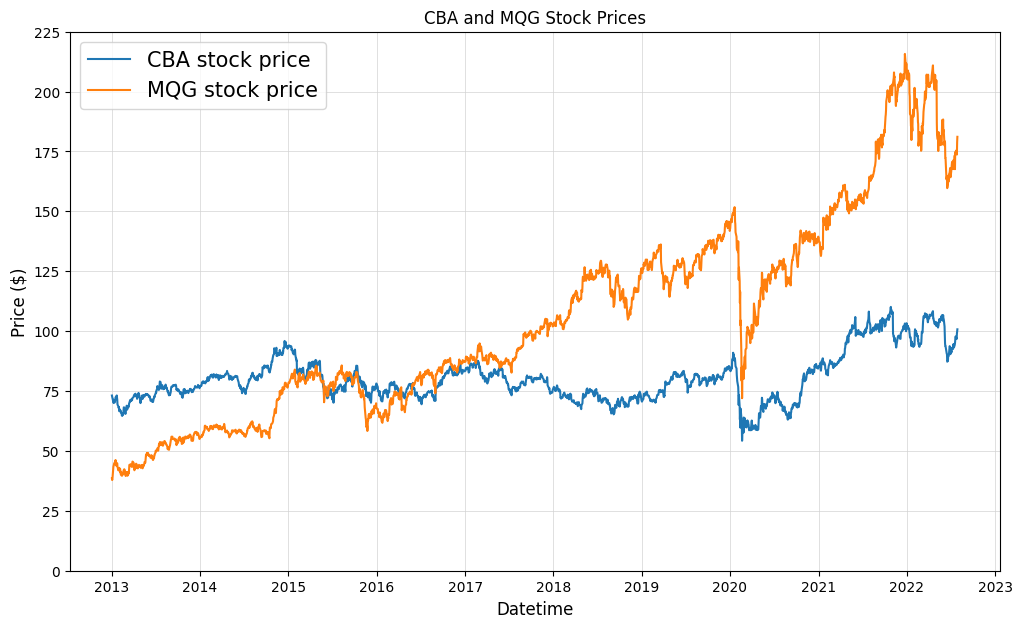

In [146]:
plt.plot(price_df.index, price_df['CBA'], label='CBA stock price')
plt.plot(price_df.index, price_df['MQG'], label='MQG stock price')
plt.title("CBA and MQG Stock Prices")
plt.legend(fontsize="15")

# Set labels and ticks
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.yticks(range(0, 250, 25))  # This will set ticks at intervals of 25 up to 250

# Design figure
fig = plt.gcf()  # Get the current figure
fig.set_size_inches(12, 7, forward=True)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)

## 5.2. Dependence of Log-Returns

In [147]:
# Linear correlation
np.corrcoef(df, rowvar = False)

array([[1.        , 0.57467128],
       [0.57467128, 1.        ]])

In [148]:
# Kendall's tau
log_ret_tau = stats.kendalltau(df['CBA'], df['MQG'])
log_ret_tau

SignificanceResult(statistic=np.float64(0.38833668127914517), pvalue=np.float64(2.4070753631598848e-179))

In [149]:
# Spearman's rho
log_ret_srho = stats.spearmanr(df, axis = 0)
log_ret_srho

SignificanceResult(statistic=np.float64(0.534188766534797), pvalue=np.float64(4.5676541415626374e-178))

In [150]:
# Required library
from pycop import empirical

# Empirical copula
em_cop = empirical(df.T.values)

# Non-parametric TDC estimates where k_l / n = 1% and k_u / n = 99%
em_cop.LTDC(0.01), em_cop.UTDC(0.99)

(np.float64(0.41459369817578773), np.float64(0.34162520729684703))

We also compute Tail dependence coefficient of *t* copula using optimal $\nu$ (degrees of freedom) and $\varrho$ (correlation) defined in Section 4 following *McNeil et al. (2015)}* as:
$$
\lambda = 2 t_{\nu + 1} \left( - \sqrt{\frac{(\nu + 1)(1 - \rho)}{1 + \rho}} \right).
$$

In [151]:
nu = cop_t_param[1]
varrho = cop_t_param[0]
value = -np.sqrt((nu + 1) * (1 - varrho) / (1 + varrho))
lambda_ = 2 * t.cdf(value, df=nu + 1)
print(lambda_)

0.35179226170002637


## 5.3 Daily log-returns time series

<Figure size 1000x500 with 0 Axes>

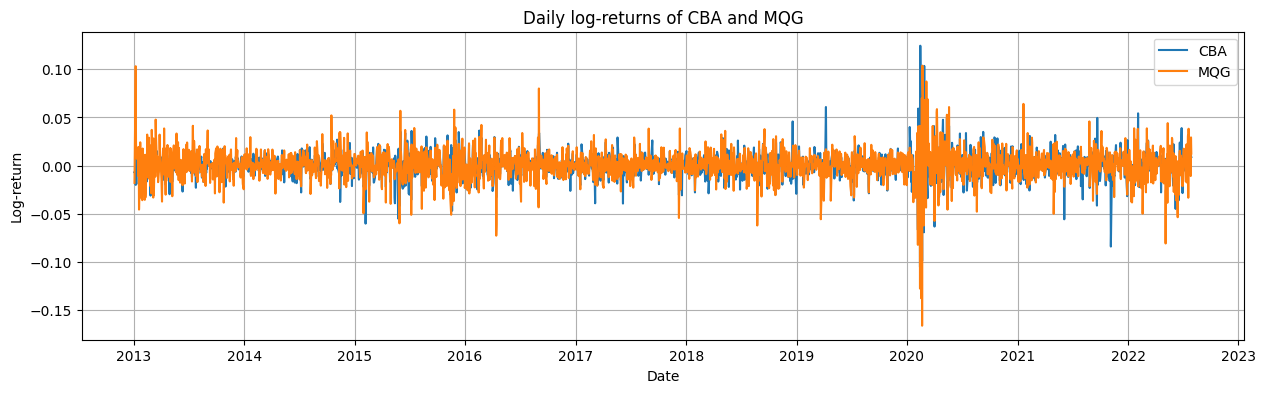

In [152]:
# Plotting the log returns
plt.figure(figsize=(10, 5))

# Edit figure size of plot log returns
plt.figure(figsize=(15, 4))
plt.plot(df.index, df['CBA'], label='CBA')
plt.plot(df.index, df['MQG'], label='MQG')

# Add title and labels
plt.title('Daily log-returns of CBA and MQG')
plt.xlabel('Date')
plt.ylabel('Log-return')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## 5.3 Non-overlapping 10-day log-returns time series

In [153]:
# Declare 10d log-return dataframe
df_10d = pd.DataFrame(columns=['Date', 'CBA', 'MQG'])

# Number of non-overlapping observations
n = math.floor(len(df)/10)

# Design historical data by excluding redundant older data:
new_df = df.iloc[len(df) - n*10:].copy()

# Transform 1-day log-returns to 10-day log-returns
for i in range(0, n):
    log_return = np.sum(new_df.iloc[i*10:i*10+10])
    # Store loss value
    new_row = [{'Date': new_df.index[i*10], 'CBA': log_return[0], 'MQG': log_return[1]}]
    df_10d = pd.concat([df_10d, pd.DataFrame(new_row)], ignore_index=True)

<Figure size 1000x500 with 0 Axes>

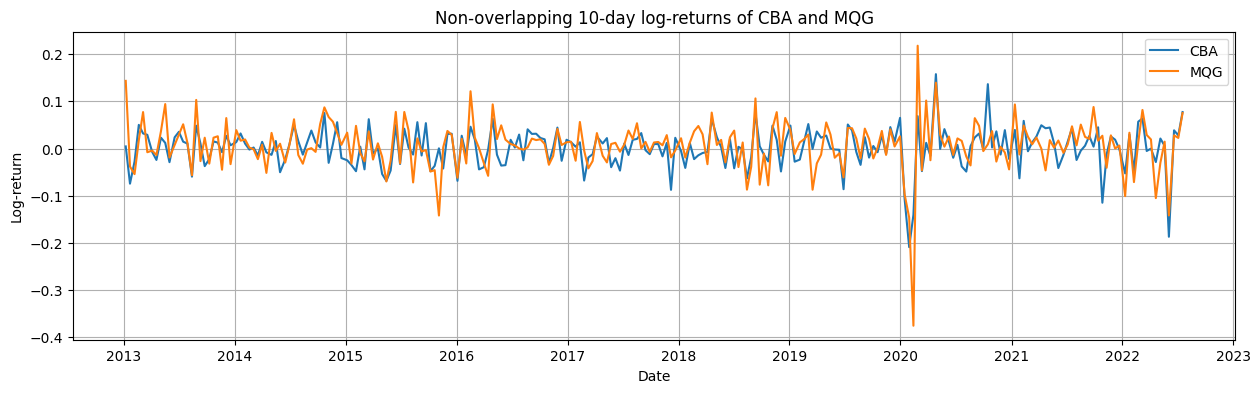

In [154]:
# Plotting the 10-day log-returns time series
plt.figure(figsize=(10, 5))

# Edit figure size of plot log returns
plt.figure(figsize=(15, 4))
plt.plot(df_10d['Date'], df_10d['CBA'], label='CBA')
plt.plot(df_10d['Date'], df_10d['MQG'], label='MQG')

# Add title and labels
plt.title('Non-overlapping 10-day log-returns of CBA and MQG')
plt.xlabel('Date')
plt.ylabel('Log-return')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## 5.4 Scatter plot of Log-returns

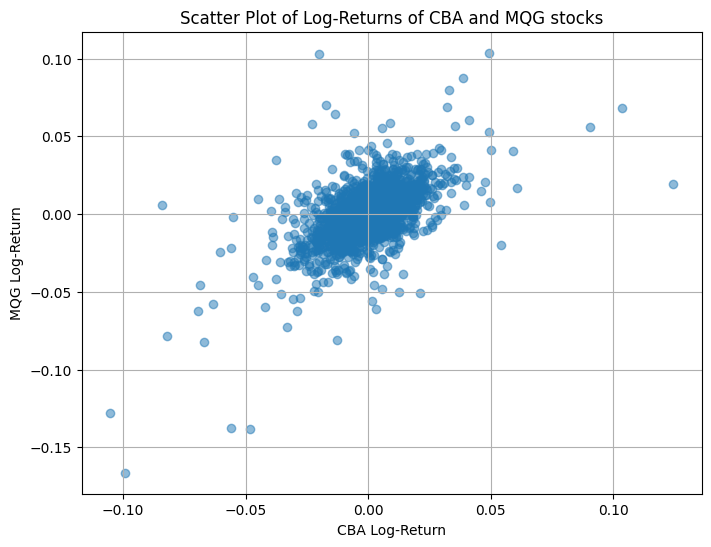

In [155]:
plt.figure(figsize=(8, 6))
plt.scatter(df['CBA'], df['MQG'], alpha=0.5)
plt.title('Scatter Plot of Log-Returns of CBA and MQG stocks')
plt.xlabel('CBA Log-Return')
plt.ylabel('MQG Log-Return')
plt.grid(True)
plt.show()

## 5.5. Profit estimates for Butterfly Spread and Strangle in various spot prices

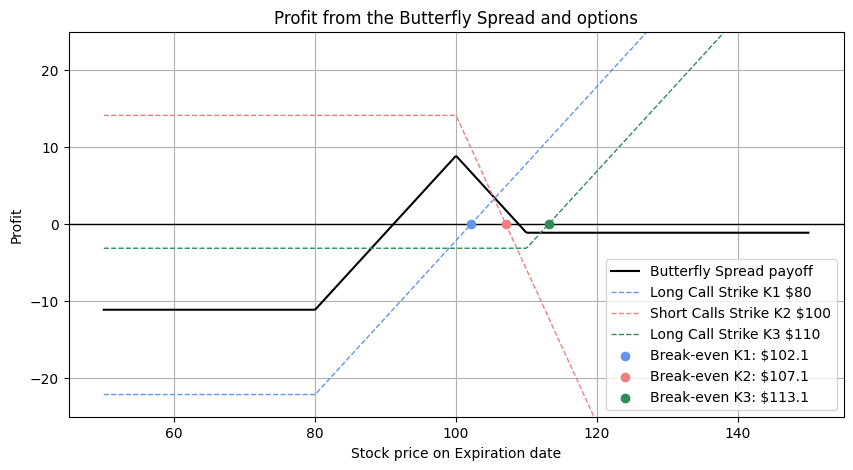

In [156]:
# Stock price range
S_price = np.linspace(50, 150, 500)

# Payoff for each option of the Butterfly Spread
B_payoff_long_call_1 = np.maximum(S_price - CBA_long_call_strike_1, 0) - B_CBA_long_call_1
B_payoff_short_call_2 = -2 * (np.maximum(S_price - CBA_short_call_strike_2, 0)) + B_CBA_short_call_2
B_payoff_long_call_3 = np.maximum(S_price - CBA_long_call_strike_3, 0) - B_CBA_long_call_3
# Total payoff of the butterfly spread
B_payoff = B_payoff_long_call_1 + B_payoff_short_call_2 + B_payoff_long_call_3

# Break-even point for each option in Butterfly Spread 
B_breakeven_long_1 = S_price[np.abs(B_payoff_long_call_1).argmin()]
B_breakeven_short_2 = S_price[np.abs(B_payoff_short_call_2).argmin()]
B_breakeven_long_3 = S_price[np.abs(B_payoff_long_call_3).argmin()]

# Plot the butterfly spread and each option payoff
plt.figure(figsize=(10, 5))
plt.ylim(-25, 25)
plt.plot(S_price, B_payoff, label='Butterfly Spread payoff', color='black')
plt.axhline(0, color='black', lw=1)

# Plot the profit line for each option in Butterfly Spread
plt.plot(S_price, B_payoff_long_call_1, color='cornflowerblue', linestyle='--', lw=1, label='Long Call Strike K1 $80')
plt.plot(S_price, B_payoff_short_call_2, color='lightcoral', linestyle='--', lw=1, label='Short Calls Strike K2 $100')
plt.plot(S_price, B_payoff_long_call_3, color='seagreen', linestyle='--', lw=1, label='Long Call Strike K3 $110')

# Mark the break-even point on the plot
plt.scatter(B_breakeven_long_1, 0, color='cornflowerblue', zorder=5, label=f'Break-even K1: ${B_breakeven_long_1:.1f}')
plt.scatter(B_breakeven_short_2, 0, color='lightcoral', zorder=5, label=f'Break-even K2: ${B_breakeven_short_2:.1f}')
plt.scatter(B_breakeven_long_3, 0, color='seagreen', zorder=5, label=f'Break-even K3: ${B_breakeven_long_3:.1f}')

# Titles and labels
plt.title('Profit from the Butterfly Spread and options')
plt.xlabel('Stock price on Expiration date')
plt.ylabel('Profit')

# Add a legend
plt.legend()

# Grid
plt.grid(True)

# Show plot
plt.show()

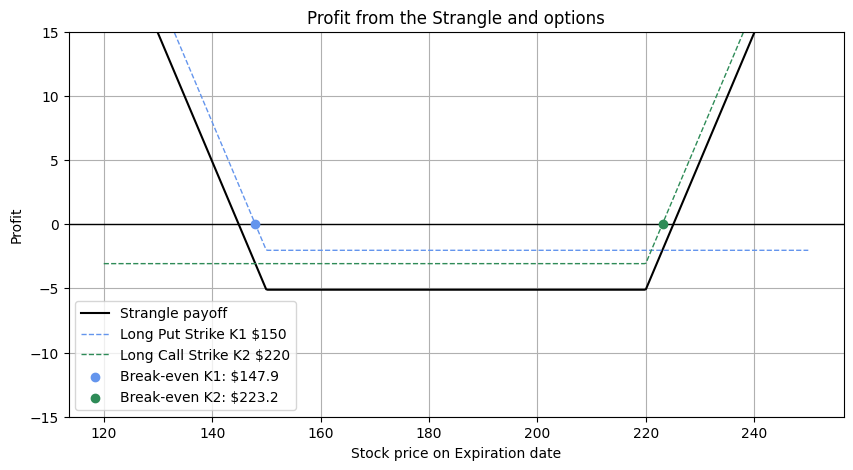

In [157]:
# Stock price range
S_price = np.linspace(120, 250, 500)

# Payoff for each option of the strangle
S_payoff_long_put_1 = np.maximum(MQG_long_put_strike_1 - S_price, 0) - S_MQG_long_put_1
S_payoff_long_call_2 = np.maximum(S_price - MQG_long_call_strike_2, 0) - S_MQG_long_call_2
# Total payoff of the butterfly spread
S_payoff = S_payoff_long_put_1 + S_payoff_long_call_2

# Break-even point for each option in Butterfly Spread 
S_breakeven_long_1 = S_price[np.abs(S_payoff_long_put_1).argmin()]
S_breakeven_long_2 = S_price[np.abs(S_payoff_long_call_2).argmin()]

# Plot the Strangle and each option payoff
plt.figure(figsize=(10, 5))
plt.ylim(-15, 15)
plt.plot(S_price, S_payoff, label='Strangle payoff', color='black')
plt.axhline(0, color='black', lw=1)

# Plot the profit line for each option in Strangle
plt.plot(S_price, S_payoff_long_put_1, color='cornflowerblue', linestyle='--', lw=1, label='Long Put Strike K1 $150')
plt.plot(S_price, S_payoff_long_call_2, color='seagreen', linestyle='--', lw=1, label='Long Call Strike K2 $220')

# Mark the break-even point on the plot
plt.scatter(S_breakeven_long_1, 0, color='cornflowerblue', zorder=5, label=f'Break-even K1: ${S_breakeven_long_1:.1f}')
plt.scatter(S_breakeven_long_2, 0, color='seagreen', zorder=5, label=f'Break-even K2: ${S_breakeven_long_2:.1f}')

# Titles and labels
plt.title('Profit from the Strangle and options')
plt.xlabel('Stock price on Expiration date')
plt.ylabel('Profit')

# Add a legend
plt.legend()

# Grid
plt.grid(True)

# Show plot
plt.show()

## Constructing results in Latex

In [158]:
# Copy the original dataframe
diversified_risk_measure = portfolio_risk_measures[portfolio_risk_measures['position']=='diversified'].copy()

# Split 'risk_measure' into two columns 'VaR' and 'ES' as numerical values
diversified_risk_measure[['VaR', 'ES']] = pd.DataFrame(diversified_risk_measure['risk_measure'].tolist(), index=diversified_risk_measure.index)

# Format the 'conf_level' to 0.XX
diversified_risk_measure['conf_level'] = diversified_risk_measure['conf_level'].apply(lambda x: f"{x:.2f}")

# Group the data by 'method', 'time_period', and 'conf_level' while keeping 'VaR' and 'ES' as floats
var_pivot = diversified_risk_measure.pivot_table(
    index=['method'], 
    columns=['time_period', 'conf_level'], 
    values=['VaR']
)

# Apply formatting to the pivot table (rounding VaR and ES)
var_pivot = var_pivot.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

# Generate LaTeX output
var_latex_code = var_pivot.to_latex(index=True, multicolumn=True, multirow=True)

# Print the LaTeX code
print(var_latex_code)

\begin{tabular}{lllllll}
\toprule
 & \multicolumn{6}{r}{VaR} \\
time_period & \multicolumn{3}{r}{1-day} & \multicolumn{3}{r}{10-day} \\
conf_level & 0.90 & 0.95 & 0.99 & 0.90 & 0.95 & 0.99 \\
method &  &  &  &  &  &  \\
\midrule
M1 & 0.41 & 0.53 & 0.75 & 1.23 & 1.60 & 2.30 \\
M2 & 0.28 & 0.39 & 0.62 & 0.72 & 1.04 & 2.25 \\
M3 & 0.24 & 0.41 & 0.62 & 0.53 & 2.89 & 2.89 \\
M4 & 0.34 & 0.44 & 0.62 & 0.86 & 1.21 & 1.88 \\
M5 & 0.35 & 0.45 & 0.62 & 0.80 & 1.08 & 1.66 \\
\bottomrule
\end{tabular}



In [159]:
# Group the data by 'method', 'time_period', and 'conf_level' while keeping 'VaR' and 'ES' as floats
es_pivot = diversified_risk_measure.pivot_table(
    index=['method'], 
    columns=['time_period', 'conf_level'], 
    values=['ES']
)

# Apply formatting to the pivot table (rounding VaR and ES)
es_pivot = es_pivot.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

# Generate LaTeX output
es_latex_code = es_pivot.to_latex(index=True, multicolumn=True, multirow=True)

# Print the LaTeX code
print(es_latex_code)

\begin{tabular}{lllllll}
\toprule
 & \multicolumn{6}{r}{ES} \\
time_period & \multicolumn{3}{r}{1-day} & \multicolumn{3}{r}{10-day} \\
conf_level & 0.90 & 0.95 & 0.99 & 0.90 & 0.95 & 0.99 \\
method &  &  &  &  &  &  \\
\midrule
M1 & 0.56 & 0.66 & 0.86 & 1.71 & 2.03 & 2.65 \\
M2 & 0.45 & 0.57 & 0.90 & 1.35 & 1.81 & 3.16 \\
M3 & 0.43 & 0.58 & 0.73 & 2.18 & 2.92 & 3.01 \\
M4 & 0.46 & 0.54 & 0.70 & 1.32 & 1.63 & 2.23 \\
M5 & 0.47 & 0.56 & 0.70 & 1.18 & 1.44 & 2.00 \\
\bottomrule
\end{tabular}



# END of Python Report